<a href="https://colab.research.google.com/github/refn06/defect-concrete-SDNet2018/blob/main/Defect_Concrete_SDNet2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Business Understanding**
---

Kerusakan berupa retakan (crack) pada beton merupakan salah satu indikator utama
penurunan kualitas struktur infrastruktur seperti jembatan dan bangunan.

Tujuan dari penelitian ini adalah membangun sistem klasifikasi citra berbasis
Deep Learning untuk mendeteksi retakan beton secara otomatis menggunakan
dataset SDNET2018 dengan model ViT.

## **Data Understanding**
---

Penelitian ini menggunakan dataset SDNET2018 (Structural Defect Network 2018) yang tersedia secara publik melalui Kaggle. Dataset ini berisi citra permukaan beton yang digunakan untuk mendeteksi keberadaan retakan (crack detection) pada struktur beton.

Dataset SDNET2018 terdiri dari tiga jenis permukaan beton, yaitu:

- Decks (permukaan dek jembatan),

- Pavements (permukaan jalan),

- Walls (dinding beton).

📌 Jumlah: ~56.000 image

📌 Label: Binary classification

Setiap citra pada dataset diklasifikasikan ke dalam dua kelas utama, yaitu:

- `Cracked` = yang menunjukkan adanya retakan pada permukaan beton, dan

- `Non-cracked` = yang menunjukkan permukaan beton tanpa retakan.

Pada penelitian ini, hanya subset Decks yang digunakan. Pemilihan subset ini dilakukan untuk memfokuskan eksperimen pada deteksi retakan pada permukaan dek jembatan, sebagaimana banyak digunakan pada penelitian sebelumnya yang berbasis SDNET2018.

### Import Library

In [1]:
import numpy as np
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

Install Library

In [2]:
!pip install vit-keras kaggle pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.1 MB/s eta 0:00:00


In [3]:
!mkdir ~/.kaggle #nyari credential
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json #biar kaggle api ngga ditolak

In [4]:
!kaggle datasets download -d aniruddhsharma/structural-defects-network-concrete-crack-images

Dataset URL: https://www.kaggle.com/datasets/aniruddhsharma/structural-defects-network-concrete-crack-images
License(s): other
 94% 474M/506M [00:01<00:00, 364MB/s]
100% 506M/506M [00:03<00:00, 168MB/s]


In [5]:
!unzip -o structural-defects-network-concrete-crack-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Walls/Non-cracked/7117-203.jpg  
  inflating: Walls/Non-cracked/7117-204.jpg  
  inflating: Walls/Non-cracked/7117-205.jpg  
  inflating: Walls/Non-cracked/7117-206.jpg  
  inflating: Walls/Non-cracked/7117-207.jpg  
  inflating: Walls/Non-cracked/7117-208.jpg  
  inflating: Walls/Non-cracked/7117-21.jpg  
  inflating: Walls/Non-cracked/7117-211.jpg  
  inflating: Walls/Non-cracked/7117-212.jpg  
  inflating: Walls/Non-cracked/7117-213.jpg  
  inflating: Walls/Non-cracked/7117-214.jpg  
  inflating: Walls/Non-cracked/7117-215.jpg  
  inflating: Walls/Non-cracked/7117-216.jpg  
  inflating: Walls/Non-cracked/7117-217.jpg  
  inflating: Walls/Non-cracked/7117-218.jpg  
  inflating: Walls/Non-cracked/7117-219.jpg  
  inflating: Walls/Non-cracked/7117-22.jpg  
  inflating: Walls/Non-cracked/7117-220.jpg  
  inflating: Walls/Non-cracked/7117-221.jpg  
  inflating: Walls/Non-cracked/7117-222.jpg  
  inflating: Walls/Non-cracked/

In [6]:
!ls
!ls Decks
!ls Pavements
!ls Walls

Decks	     Pavements	  structural-defects-network-concrete-crack-images.zip
kaggle.json  sample_data  Walls
Cracked  Non-cracked
Cracked  Non-cracked
Cracked  Non-cracked


In [7]:
#Jumlah Data per Kelas
base_path = "/content/Decks"

for cls in os.listdir(base_path):
    cls_path = os.path.join(base_path, cls)
    if os.path.isdir(cls_path):
        print(f"\nClass: {cls}")
        print("Jumlah file:", len(os.listdir(cls_path)))
        print("Contoh file:", os.listdir(cls_path)[:5])


Class: Non-cracked
Jumlah file: 11595
Contoh file: ['7043-52.jpg', '7018-80.jpg', '7013-72.jpg', '7025-44.jpg', '7026-213.jpg']

Class: Cracked
Jumlah file: 2025
Contoh file: ['7011-18.jpg', '7028-177.jpg', '7037-146.jpg', '7018-64.jpg', '7049-120.jpg']


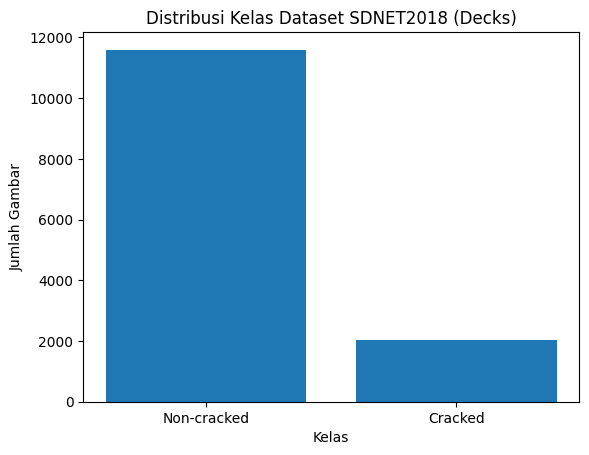

In [8]:
# Visualisasi Distribusi kelas
classes = os.listdir(base_path)
class_counts = {}

for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(base_path, cls)))

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribusi Kelas Dataset SDNET2018 (Decks)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

Berdasarkan visualisasi distribusi kelas, dataset menunjukkan ketidakseimbangan data (class imbalance), di mana jumlah citra pada kelas Non-cracked jauh lebih banyak dibandingkan kelas Cracked. Kondisi ini berpotensi memengaruhi performa model, terutama dalam mengenali kelas minoritas.

# **Data Preparation**
---
Tujuan: Menyiapkan dataset agar siap digunakan pada proses training model CNN (dan nanti ViT), termasuk pembagian data, normalisasi, dan penanganan ketidakseimbangan kelas.

In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define path & Split Ratio
BASE_DIR = "/content/Decks"
OUTPUT_DIR = "/content/Decks_split"

classes = ["Cracked", "Non-cracked"]

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

# Data Splitting (Train/Val/Test)
for cls in classes:
    files = os.listdir(os.path.join(BASE_DIR, cls))
    random.shuffle(files)

    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val   = int(val_ratio * n_total)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    for split, split_files in zip(
        ["train", "val", "test"],
        [train_files, val_files, test_files]
    ):
        dst_dir = os.path.join(OUTPUT_DIR, split, cls)
        os.makedirs(dst_dir, exist_ok=True)

        for f in split_files:
            shutil.copy(
                os.path.join(BASE_DIR, cls, f),
                os.path.join(dst_dir, f)
            )

print("Dataset berhasil di-split")

Dataset berhasil di-split


Dataset kemudian dibagi menjadi tiga bagian, yaitu:
- data latih (training set) sebesar 70%,
- data validasi (validation set) sebesar 15%, dan
- data uji (test set) sebesar 15%.

Pembagian dilakukan secara acak (random sampling) dengan
random seed untuk memastikan reprodusibilitas eksperimen.

In [10]:
# Hasil split
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}")
    for cls in classes:
        path = os.path.join(OUTPUT_DIR, split, cls)
        print(cls, ":", len(os.listdir(path)))


TRAIN
Cracked : 1417
Non-cracked : 8116

VAL
Cracked : 303
Non-cracked : 1739

TEST
Cracked : 305
Non-cracked : 1740


Pada tahap ini, dataset citra beton dipisahkan ke dalam tiga subset, yaitu data pelatihan (training), data validasi (validation), dan data pengujian (testing) dengan rasio 70:15:15.

Pembagian dilakukan secara acak dengan memastikan bahwa setiap citra hanya berada pada satu subset untuk menghindari terjadinya data leakage.

Hasil pembagian menunjukkan distribusi kelas yang konsisten pada setiap subset, sebagaimana ditunjukkan oleh jumlah data pada masing-masing kelas cracked dan non-cracked.

### Load Dataset

In [11]:
# Data Loader (TensorFlow Dataset)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(OUTPUT_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(OUTPUT_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

Found 9533 files belonging to 2 classes.
Found 2042 files belonging to 2 classes.


In [12]:
print(f"Jumlah data training   : {train_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"Jumlah data validation : {val_ds.cardinality().numpy() * BATCH_SIZE}")

Jumlah data training   : 9536
Jumlah data validation : 2048


Dataset training dan validation berhasil dimuat dengan masing-masing
terdiri dari 9.533 dan 2.042 citra, yang terbagi ke dalam dua kelas
(Cracked dan Non-cracked).

<Figure size 1200x1200 with 0 Axes>

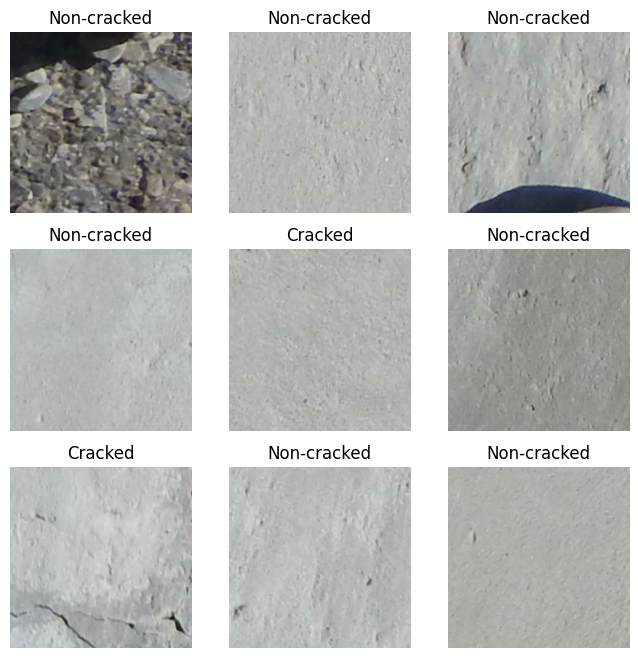

In [13]:
import matplotlib.pyplot as plt
import os

# Retrieve class names from the directory structure, assuming alphabetical order matches label mapping
class_names = sorted(os.listdir(os.path.join(OUTPUT_DIR, "train")))

plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8,8))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

### Distribusi label training set

In [14]:
from collections import Counter

labels = np.concatenate([y.numpy().flatten() for x, y in train_ds])
print(Counter(labels))

Counter({np.float32(1.0): 8116, np.float32(0.0): 1417})


| Kelas           | Jumlah | Persentase |
| --------------- | ------ | ---------- |
| Cracked (1)     | 8116   | **85.1%**  |
| Non-cracked (0) | 1417   | **14.9%**  |


class weight dipakai, karena class imbalance ada di data train-nya

### Handling Imbalance

Class weight digunakan untuk menangani ketidakseimbangan data, di mana kelas minoritas diberikan bobot lebih besar agar model tidak bias terhadap kelas mayoritas.

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight = dict(zip(np.unique(labels), class_weights))
print(class_weight)

{np.float32(0.0): np.float64(3.3637967537050106), np.float32(1.0): np.float64(0.5872966978807295)}


Nilai tersebut menunjukkan bahwa:

- Kelas `0` memiliki bobot yang lebih besar (3.36), yang mengindikasikan bahwa jumlah data pada kelas ini lebih sedikit dibandingkan kelas lainnya.

- Kelas `1` memiliki bobot lebih kecil (0.59) karena jumlah datanya lebih dominan.

Dengan penerapan class weight ini, model akan memberikan penalti yang lebih besar ketika salah mengklasifikasikan data dari kelas minoritas.

### Normalisasi & Performance Optimization

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

# Normalisasi pixel (0–255 → 0–1)
train_ds = train_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

In [17]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels[:10])

(32, 224, 224, 3)
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)


Normalisasi piksel dilakukan untuk menyamakan skala input (0–1) sehingga meningkatkan stabilitas dan efisiensi proses pelatihan model.

| Dimensi | Arti                                      |
| ------- | ----------------------------------------- |
| 32      | **Batch size** (1 batch berisi 32 gambar) |
| 224     | Tinggi gambar                             |
| 224     | Lebar gambar                              |
| 3       | Channel warna (**RGB**)                   |


224×224×3 = gold standard pretrained model (ResNet, EfficientNet, ViT).

Binary classification

1.0 dan 0.0 = dua kelas

Shape (10, 1) normal karena:

label_mode="binary"

TensorFlow otomatis pakai float

# **Modelling**
---

## Baseline CNN (from scratch)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [19]:
model = build_baseline_cnn()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.8155 - loss: 0.4807 - precision: 0.8481 - recall: 0.9501 - val_accuracy: 0.8516 - val_loss: 0.4256 - val_precision: 0.8516 - val_recall: 1.0000
Epoch 2/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8503 - loss: 0.4287 - precision: 0.8503 - recall: 1.0000 - val_accuracy: 0.8516 - val_loss: 0.4237 - val_precision: 0.8516 - val_recall: 1.0000
Epoch 3/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8496 - loss: 0.4264 - precision: 0.8496 - recall: 1.0000 - val_accuracy: 0.8516 - val_loss: 0.4209 - val_precision: 0.8516 - val_recall: 1.0000
Epoch 4/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8501 - loss: 0.4255 - precision: 0.8501 - recall: 1.0000 - val_accuracy: 0.8516 - val_loss: 0.4190 - val_precision: 0.8516 - val_recall: 1.0000
Epoch 5/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.8505 - loss: 0.4281 - precision: 0.8505 - recall: 1.0000 - val_accuracy: 0.8516 - va

### Evaluation

training tanpa class weight, nebak kelas mayoritas doang dan mengabaikan kelas minoritas

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for x, y in val_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(y.numpy().ravel())
    y_pred.extend((preds > 0.5).astype(int).ravel())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       303
         1.0       0.85      1.00      0.92      1739

    accuracy                           0.85      2042
   macro avg       0.43      0.50      0.46      2042
weighted avg       0.73      0.85      0.78      2042

Confusion Matrix:
[[   0  303]
 [   0 1739]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
class_weight = {
    0: 3.3637967537050106, # Cracked
    1: 0.5872966978807295 # Non-craked
}

pake class_weight karena dipaksa harus lebih perhatiin kelas minoritas jadi anjlok